# In this tutorial we will build basic CNN for image classification.
Author :- Ankur Mali
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [86]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79


# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [87]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None, batch_norm="preact"):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.bn4 = tf.keras.layers.BatchNormalization()
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()
        self.batch_norm = batch_norm

    def predict_preact(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x

    def predict_postact(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = tf.nn.relu(x)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.bn2(x, training=training)
        x = self.pool1(x)

        x = self.conv3(x)
        x = tf.nn.relu(x)
        x = self.bn3(x, training=training)
        x = self.pool1(x)

        x = self.conv4(x)
        x = tf.nn.relu(x)
        x = self.bn4(x, training=training)
        x = self.pool1(x)

        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        if self.batch_norm == "preact":
          preds = self.predict_preact(images, training)
        
        elif self.batch_norm == "postact":
          preds = self.predict_postact(images, training)
        
        else:
          import sys
          print ("INVALID BATCH NORM CRITERIA")
          sys.exit()
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
          
        #variables_names = [v.name for v in self.variables]
        #print (f"GRAD FN:Length - {len(self.variables)}, Variables: {variables_names}")
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            if self.batch_norm == "preact":
              dummy_pred = self.predict_preact(dummy_input, training=False)
            else:
              dummy_pred = self.predict_postact(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            if self.batch_norm == "preact":
              logits = self.predict_preact(images, training=False)
            else:
              logits = self.predict_postact(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        

        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)

                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))

                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [96]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
# Instantiate model. This doesn't initialize the variables yet.
model_postact = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory,batch_norm="postact")

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [97]:
# Train model
model_postact.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
          early_stopping_rounds=10, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  1.0136367
Train Acc at epoch 1:  0.65014315
Eval loss at epoch 1:  0.9988546
Eval Acc at epoch 1:  0.6474542
Train loss at epoch 2:  0.041066226
Train Acc at epoch 2:  0.74047744
Eval loss at epoch 2:  0.04925299
Eval Acc at epoch 2:  0.8102062
Train loss at epoch 4:  0.020186799
Train Acc at epoch 4:  0.88691163
Eval loss at epoch 4:  0.045423333
Eval Acc at epoch 4:  0.9009294
Train loss at epoch 6:  0.0077015962
Train Acc at epoch 6:  0.9265962
Eval loss at epoch 6:  0.03463325
Eval Acc at epoch 6:  0.93261516
Train loss at epoch 8:  0.010140479
Train Acc at epoch 8:  0.94475967
Eval loss at epoch 8:  0.044770673
Eval Acc at epoch 8:  0.948002
Train loss at epoch 10:  0.0064851576
Train Acc at epoch 10:  0.95553106
Eval loss at epoch 10:  0.040013045
Eval Acc at epoch 10:  0.9576494
Train loss at epoch 12:  0.019077843
Train Acc at epoch 12:  0.96242756
Eval loss at epoch 12:  0.0629949
Eval Acc at epoch 12:  0.96367866
Train loss at epoch 14:  0.006223333
Tr

In [98]:
for step, (images, target) in enumerate(test_dataset):
    loss = model_postact.loss_fn(images, target, False)
    accuracy = model_postact.compute_accuracy_2(images,target)

In [99]:
tf.keras.metrics.Mean('loss_test')(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3976562e-05>

In [100]:
tf.keras.metrics.Mean('acc_test')(accuracy)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9722237>

In [101]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
# Instantiate model. This doesn't initialize the variables yet.
model_preact = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory,batch_norm="preact")

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [102]:
# Train model
model_preact.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=10, 
          early_stopping_rounds=10, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  1.7153848
Train Acc at epoch 1:  0.34574747
Eval loss at epoch 1:  1.702257
Eval Acc at epoch 1:  0.34122995
Train loss at epoch 2:  0.033808663
Train Acc at epoch 2:  0.5189435
Eval loss at epoch 2:  0.043192573
Eval Acc at epoch 2:  0.6519207
Train loss at epoch 4:  0.026600964
Train Acc at epoch 4:  0.7983858
Eval loss at epoch 4:  0.04066246
Eval Acc at epoch 4:  0.82387227
Train loss at epoch 6:  0.015944453
Train Acc at epoch 6:  0.87084687
Eval loss at epoch 6:  0.03807901
Eval Acc at epoch 6:  0.88147473
Train loss at epoch 8:  0.012583611
Train Acc at epoch 8:  0.9042992
Eval loss at epoch 8:  0.037670527
Eval Acc at epoch 8:  0.9100999
Train loss at epoch 10:  0.0093951095
Train Acc at epoch 10:  0.9163023
Eval loss at epoch 10:  0.03735969
Eval Acc at epoch 10:  0.92035085


In [103]:
def test_model(model, data):
    model.history['test_loss'] = []
    model.history['test_acc'] = []
    acc_test = tf.keras.metrics.Mean('test_acc')
    test_loss = tf.keras.metrics.Mean('test_loss')
    for step, (images, target) in enumerate(data):
        loss = model.loss_fn(images, target, False)
        accuracy = model.compute_accuracy_2(images,target)
        #print (f"Loss: {loss}")
        #print (f"Accuracy : {accuracy}")
        acc_test(accuracy)
        test_loss(loss)
        #print (acc_test.result())
        #print (test_loss.result())
    model.history['test_loss'].append(test_loss.result().numpy())
    model.history['test_acc'].append(acc_test.result().numpy())
    # Reset metrics
    test_loss.reset_states()
    acc_test.reset_states()

    print(f"Test loss {model.history['test_loss'][-1]}")
    print(f"Test Acc {model.history['test_acc'][-1]}")

In [104]:
test_model(model_preact, test_dataset)

Test loss 0.0377860963344574
Test Acc 0.9214552640914917


In [106]:
model_preact.history

DictWrapper({'train_loss': ListWrapper([1.7153848, 0.033808663, 0.037996083, 0.026600964, 0.01258595, 0.015944453, 0.011721668, 0.012583611, 0.2681731, 0.0093951095]), 'eval_loss': ListWrapper([1.702257, 0.043192573, 0.05658758, 0.04066246, 0.036848508, 0.03807901, 0.037324883, 0.037670527, 0.2759319, 0.03735969]), 'train_acc': ListWrapper([0.34574747, 0.5189435, 0.7186159, 0.7983858, 0.8427083, 0.87084687, 0.8901514, 0.9042992, 0.91166365, 0.9163023]), 'val_acc': ListWrapper([0.34122995, 0.6519207, 0.7668183, 0.82387227, 0.85864943, 0.88147473, 0.8978832, 0.9100999, 0.9124228, 0.92035085]), 'test_loss': ListWrapper([0.037786096]), 'test_acc': ListWrapper([0.92145526])})

In [107]:
model_postact.history

DictWrapper({'train_loss': ListWrapper([1.0136367, 0.041066226, 0.04845216, 0.020186799, 0.015862511, 0.0077015962, 0.020116484, 0.010140479, 0.010556692, 0.0064851576, 0.011482169, 0.019077843, 0.00428134, 0.006223333, 0.006061254, 0.0067927907]), 'eval_loss': ListWrapper([0.9988546, 0.04925299, 0.06532862, 0.045423333, 0.04673805, 0.03463325, 0.051276766, 0.044770673, 0.045680296, 0.040013045, 0.049008995, 0.0629949, 0.042178925, 0.044241093, 0.05117779, 0.05043658]), 'train_acc': ListWrapper([0.65014315, 0.74047744, 0.84471244, 0.88691163, 0.91104007, 0.9265962, 0.93720573, 0.94475967, 0.95074564, 0.95553106, 0.9594141, 0.96242756, 0.96497625, 0.96736866, 0.96939987, 0.97113997]), 'val_acc': ListWrapper([0.6474542, 0.8102062, 0.86967003, 0.9009294, 0.9197072, 0.93261516, 0.94123954, 0.948002, 0.95329267, 0.9576494, 0.9610695, 0.96367866, 0.96624583, 0.96843094, 0.9703101, 0.97193485])})

In [108]:
test_model(model_postact, test_dataset)

Test loss 0.03316536918282509
Test Acc 0.9723150730133057


In [109]:
model_postact.history

DictWrapper({'train_loss': ListWrapper([1.0136367, 0.041066226, 0.04845216, 0.020186799, 0.015862511, 0.0077015962, 0.020116484, 0.010140479, 0.010556692, 0.0064851576, 0.011482169, 0.019077843, 0.00428134, 0.006223333, 0.006061254, 0.0067927907]), 'eval_loss': ListWrapper([0.9988546, 0.04925299, 0.06532862, 0.045423333, 0.04673805, 0.03463325, 0.051276766, 0.044770673, 0.045680296, 0.040013045, 0.049008995, 0.0629949, 0.042178925, 0.044241093, 0.05117779, 0.05043658]), 'train_acc': ListWrapper([0.65014315, 0.74047744, 0.84471244, 0.88691163, 0.91104007, 0.9265962, 0.93720573, 0.94475967, 0.95074564, 0.95553106, 0.9594141, 0.96242756, 0.96497625, 0.96736866, 0.96939987, 0.97113997]), 'val_acc': ListWrapper([0.6474542, 0.8102062, 0.86967003, 0.9009294, 0.9197072, 0.93261516, 0.94123954, 0.948002, 0.95329267, 0.9576494, 0.9610695, 0.96367866, 0.96624583, 0.96843094, 0.9703101, 0.97193485]), 'test_loss': ListWrapper([0.03316537]), 'test_acc': ListWrapper([0.9723151])})

## Inference code

In [110]:
batch_norm_list = ["preact", "postact"]
random_seeds = list(np.random.randint(low=1000, high=100000, size=3))
print (f"Generated seeds: {random_seeds}")

Generated seeds: [93975, 59067, 35086]


In [124]:
import json
checkpoint_directory = 'models_checkpoints/mnist/'
#dict wrappers with seed as key
inference_result_final = {"preact":{}, "postact":{}}

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)
num_epochs=20
#Keeping early stopping high for result comparison
early_stopping_rounds=20

for batch_norm in batch_norm_list:
  print (f"## Processing for batch norm mode - {batch_norm} ##")
  seed_result_dict = {}

  for cur_seed in random_seeds:
    print (f"*** Current seed: {cur_seed} ***")
    np.random.seed(cur_seed)
    tf.random.set_seed(cur_seed)
    # Instantiate model. This doesn't initialize the variables yet.
    model = ImageRecognitionCNN(num_classes=10, device=device,batch_norm=batch_norm,checkpoint_directory=checkpoint_directory, )
    # Train model
    model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=num_epochs, early_stopping_rounds=early_stopping_rounds,
                 verbose=2, train_from_scratch=True)
    test_model(model, test_dataset)

    print ("##Generated history from the model##")
    print (model.history)
    seed_result_dict[cur_seed] = model.history
  
  print (f"$$$ Results obtained for mode :{batch_norm} $$$")
  print (seed_result_dict)

  inference_result_final[batch_norm] = seed_result_dict

  with open('fmnist_stats_bnorm_cnn.json', 'w') as convert_file:
    convert_file.write(json.dumps(str(inference_result_final)))
print ("## Final inference results ##")
print (inference_result_final)







## Processing for batch norm mode - preact ##
*** Current seed: 93975 ***
Train loss at epoch 1:  1.5020629
Train Acc at epoch 1:  0.46342972
Eval loss at epoch 1:  1.4894319
Eval Acc at epoch 1:  0.4595167
Train loss at epoch 2:  0.111513734
Train Acc at epoch 2:  0.59823185
Eval loss at epoch 2:  0.11371566
Eval Acc at epoch 2:  0.7012092
Train loss at epoch 4:  0.017374333
Train Acc at epoch 4:  0.8270072
Eval loss at epoch 4:  0.036414247
Eval Acc at epoch 4:  0.84910727
Train loss at epoch 6:  0.01920261
Train Acc at epoch 6:  0.8878606
Eval loss at epoch 6:  0.053478215
Eval Acc at epoch 6:  0.8968813
Train loss at epoch 8:  0.013006775
Train Acc at epoch 8:  0.9163624
Eval loss at epoch 8:  0.045375794
Eval Acc at epoch 8:  0.92137563
Train loss at epoch 10:  0.02955879
Train Acc at epoch 10:  0.9328568
Eval loss at epoch 10:  0.057921425
Eval Acc at epoch 10:  0.9357214
Train loss at epoch 12:  0.0034335377
Train Acc at epoch 12:  0.9437852
Eval loss at epoch 12:  0.03271551
Ev

# extracting test accuracies across seeds

In [129]:
random_seeds

[93975, 59067, 35086]

In [135]:
act = ["preact", "postact"]
test_acc_dict = {}
for cur_act in act:
  test_acc_list = []
  for seed in random_seeds:
    test_acc_list.append(inference_result_final[cur_act][seed]['test_acc'][0])
  test_acc_dict[cur_act] = test_acc_list
test_acc_dict

{'postact': [0.970823, 0.97682315, 0.95377696],
 'preact': [0.9658489, 0.98344964, 0.9601051]}

In [144]:
# Calculating variance in test accuracies across seeds between pre and post act
preact_test_acc_var = np.var(test_acc_dict['preact'])
postact_test_acc_var = np.var(test_acc_dict['postact'])
preact_test_acc_var, postact_test_acc_var

(9.86381e-05, 9.52996e-05)

# extracting test losses across seeds

In [137]:
act = ["preact", "postact"]
test_loss_dict = {}
for cur_act in act:
  test_loss_list = []
  for seed in random_seeds:
    test_loss_list.append(inference_result_final[cur_act][seed]['test_loss'][0])
  test_loss_dict[cur_act] = test_loss_list
test_loss_dict

{'postact': [0.035087366, 0.03538838, 0.022961156],
 'preact': [0.03114769, 0.031808954, 0.040787797]}

In [143]:
# Calculating variance in test loss across seeds between pre and post act
preact_test_loss_var = np.var(test_loss_dict['preact'])
postact_test_loss_var = np.var(test_loss_dict['postact'])
preact_test_loss_var, postact_test_loss_var

(1.9332061e-05, 3.350794e-05)

# Extracting train losses across seeds and obtaining average loss

In [139]:
np.mean(inference_result_final[cur_act][seed]['train_loss'])

0.23868184

In [141]:
act = ["preact", "postact"]
avg_train_loss_dict = {}
for cur_act in act:
  avg_train_loss_list = []
  for seed in random_seeds:
    avg_train_loss_list.append(np.mean(inference_result_final[cur_act][seed]['train_loss']))
  avg_train_loss_dict[cur_act] = avg_train_loss_list
avg_train_loss_dict

{'postact': [0.108825244, 0.07337411, 0.23868184],
 'preact': [0.09407832, 0.046354193, 0.10335843]}

In [142]:
# Calculating variance in average loss across seeds between pre and post act
preact_avg_loss_var = np.var(avg_train_loss_dict['preact'])
postact_avg_loss_var = np.var(avg_train_loss_dict['postact'])
preact_avg_loss_var, postact_avg_loss_var

(0.00062368845, 0.0050495737)

# Plotting accuracy vs epoch to show improvement across epochs

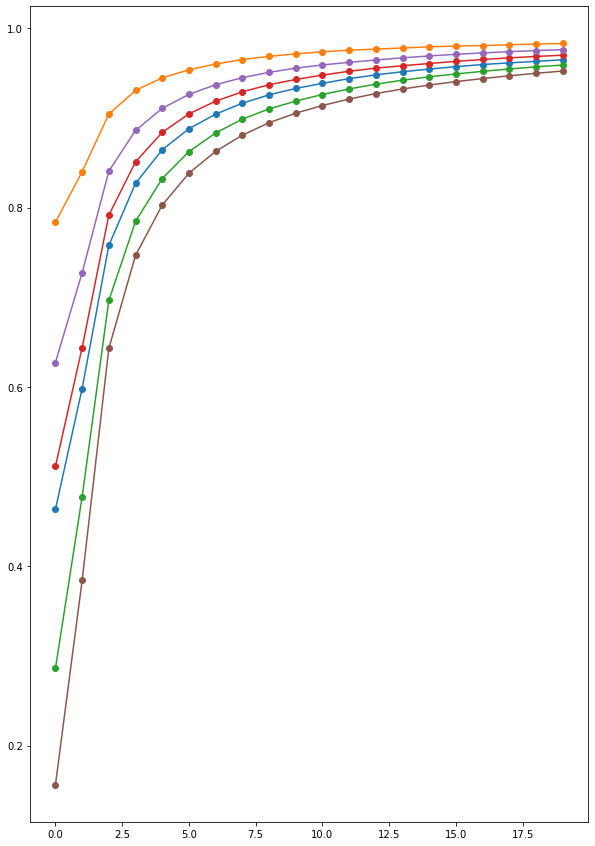

In [165]:
plt.figure(figsize=(10,15))
act = ["preact", "postact"]
train_loss_dict = {}
for cur_act in act:
  train_loss_list = []
  for seed in random_seeds:
    cur_lis = list(inference_result_final[cur_act][seed]['train_acc'])
    train_loss_list.append(cur_lis)
    plt.plot(list(range(20)),cur_lis,marker="o")
  train_loss_dict[cur_act] = train_loss_list